Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [14]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
q3 = -q2 + q4
q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | previous link | successive links | $a$ | $\alpha$ | $d$ | $\theta$ |
|--------------|---------------|------------------|-----|----------|-----|----------|

In [4]:
robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
                      (1,   0,  [2, 4], 0, 0, -0.21537, q1),
                      (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
                      (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
                      (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
                      (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

# robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
#                       (1,   0,  [2],    0,      0,              -0.21537,   q1),
#                       (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
#                       (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

In [5]:
robot_def.coordinates

In [6]:
robot_def.std_params

In [7]:
robot_def.bary_params

## Create kinematics chain

In [8]:
geom = Geometry(robot_def)


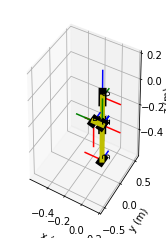

In [9]:
geom.draw_geom()

In [10]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics object


In [19]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions...
Joint 0 type: A
Joint 1 type: R
dq1_da0 = 1, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da1 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da2 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
Joint 2 type: R
dq2_da0 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da1 = 1, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da2 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
Joint 3 type: R
dq3_da0 = 0, tau_f = Fc3*sign(-dq2 + dq4) + Fo3 + Fv3*(-dq2 + dq4)
dq3_da1 = -1, tau_f = Fc3*sign(-dq2 + dq4) + Fo3 + Fv3*(-dq2 + dq4)
dq3_da2 = 1, tau_f = Fc3*sign(-dq2 + dq4) + Fo3 + Fv3*(-dq2 + dq4)
Joint 4 type: R
dq4_da0 = 0, tau_f = Fc4*sign(dq4) + Fo4 + Fv4*dq4
dq4_da1 = 0, tau_f = Fc4*sign(dq4) + Fo4 + Fv4*dq4
dq4_da2 = 1, tau_f = Fc4*sign(dq4) + Fo4 + Fv4*dq4
Joint 5 type: R
dq5_da0 = 0, tau_f = Fc5*sign(dq2 - dq4) + Fo5 + Fv5*(dq2 - dq4)
dq5_da1 = 1, tau_f = Fc5*sign(dq2 - dq4) + Fo5 + Fv5*(dq2 - dq4)
dq5_da2 = -1, tau_f = Fc5*sign(dq2 - d

In [30]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 29
Creating H_b function...


In [29]:
sympy.Matrix(dyn.base_param)

⎡                     -0.35842294⋅l2x + 1.0⋅l3x - 0.1⋅m₃                     ⎤
⎢                                                                            ⎥
⎢                                  1.0⋅l5y                                   ⎥
⎢                                                                            ⎥
⎢                                  1.0⋅l3y                                   ⎥
⎢                                                                            ⎥
⎢                        1.0⋅l2x + 1.0⋅l5x + 0.279⋅m₃                        ⎥
⎢                                                                            ⎥
⎢                            1.0⋅L2xy + 1.0⋅L5xy                             ⎥
⎢                                                                            ⎥
⎢                            1.0⋅L3xy + 1.0⋅L4xy                             ⎥
⎢                                                                            ⎥
⎢                            1.0⋅L2yz + 1.0⋅L5yz    

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [31]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 462848.657538
x: [0.08521971 0.06113792 0.00149315 0.08435045 0.03984049 0.01985968
 0.00794423 0.02843322 0.05694449 0.07514358 0.06358621 0.04944538
 0.01596943 0.24267305 0.05072941 0.02257395 0.03159083 0.01931502
 0.09393267 0.02232638 0.02037638 0.04936748 0.03243798 0.05100935
 0.00228704 0.05373242 0.0405965  0.07636748 0.05047953 0.09858983
 0.00508034 0.07408473 0.02518396 0.04223576 0.08652484 0.02860636
 0.09708753 0.01705766 0.02017435]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    0.2532
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f          462849             0

	Variables (c - continuous, i - integer, d - discrete

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


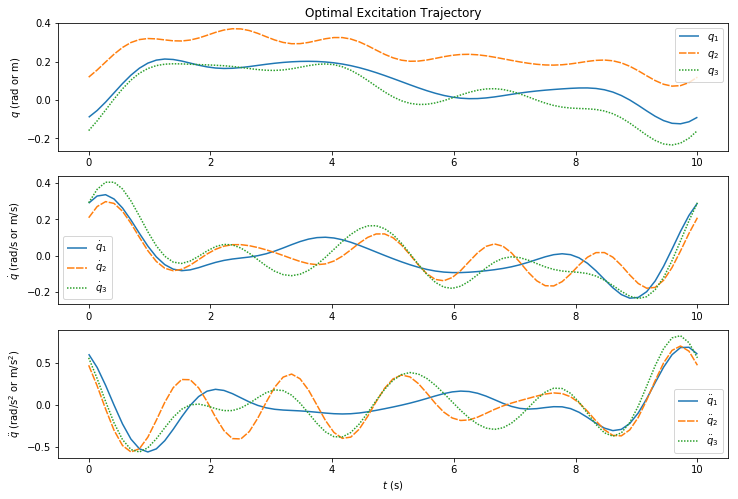

In [32]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [33]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [34]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [35]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [36]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [37]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


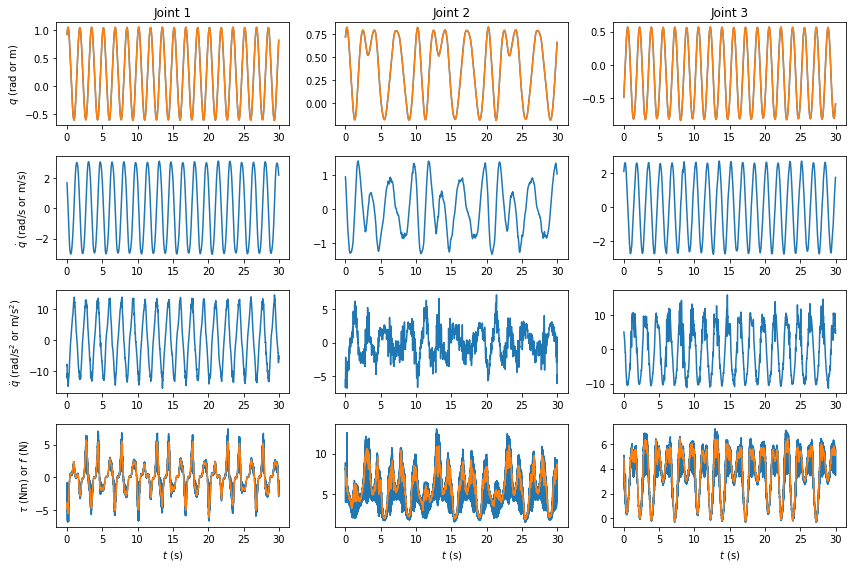

In [38]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [39]:
traj_optimizer.x_result

array([0.08521971, 0.06113792, 0.00149315, 0.08435045, 0.03984049,
       0.01985968, 0.00794423, 0.02843322, 0.05694449, 0.07514358,
       0.06358621, 0.04944538, 0.01596943, 0.24267305, 0.05072941,
       0.02257395, 0.03159083, 0.01931502, 0.09393267, 0.02232638,
       0.02037638, 0.04936748, 0.03243798, 0.05100935, 0.00228704,
       0.05373242, 0.0405965 , 0.07636748, 0.05047953, 0.09858983,
       0.00508034, 0.07408473, 0.02518396, 0.04223576, 0.08652484,
       0.02860636, 0.09708753, 0.01705766, 0.02017435])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [40]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [41]:
print(W_b.shape, tau_s.shape)

((17970, 29), (17970,))


In [42]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [43]:
xb_ols

array([ 2.06176900e-01,  7.17380598e-01,  3.83911596e-01,  2.40267823e+00,
       -4.51031770e-02, -5.05291111e-02,  2.69323408e-03,  1.48289903e-02,
        1.98842264e-02,  4.09798701e-03, -1.85657025e-03,  1.54725970e-01,
       -3.23028989e-01, -9.11088091e-02,  4.39159916e-02,  3.60382396e-01,
        1.30100301e-01, -1.07044836e-02, -1.16147977e-01, -7.21494373e-02,
        7.97459296e-01, -8.00558481e-03,  7.02748896e-03,  7.48636944e-02,
       -6.39446331e-01, -1.80227633e+00, -2.41279948e-02,  1.80546977e-02,
       -3.56547830e-02])

## Compare measured torque and predicted torque

### Generate predicted torque

In [44]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [45]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.004886625951512141
standard deviation of xb using OLS:
[0.00077741 0.00116185 0.00064894 0.00322375 0.00015269 0.00026677
 0.00018039 0.00026112 0.00113578 0.00045051 0.00035529 0.00069912
 0.00064977 0.00129681 0.00134389 0.00065411 0.00063749 0.00134906
 0.00040577 0.00268143 0.01046419 0.00275334 0.00090345 0.00136419
 0.02904778 0.00433447 0.00218455 0.00239787 0.00198475]
percentage of standard deviation of xb using OLS: 
[0.0037706  0.00161957 0.00169034 0.00134173 0.00338528 0.00527943
 0.06697953 0.01760849 0.05711963 0.10993448 0.19137001 0.00451843
 0.00201148 0.01423359 0.03060147 0.00181504 0.00490002 0.12602771
 0.00349356 0.03716493 0.01312191 0.34392788 0.12855886 0.01822227
 0.04542646 0.002405   0.09054007 0.13281158 0.05566585]


### Plot measured torque and predicted torque

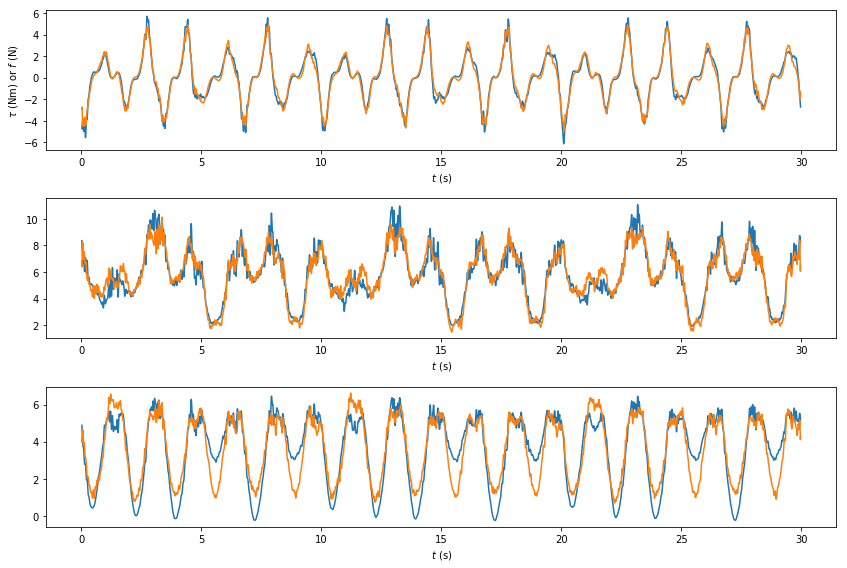

In [46]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

In [25]:
robot_def.params

## Convex optimization

In [26]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

[ 4.51759594e-01 -5.50129960e-04  7.21406441e-02 -2.03789196e-02
  7.79418804e-04  8.39004192e-01  1.42708260e-02  3.04222130e-03
  1.04918787e-01  1.21380433e-04 -9.80113090e-04  1.30898057e-01
  4.97529618e-02  1.79097965e-01  3.10781502e-01]


In [27]:
# xb_ols

array([ 4.51759594e-01, -5.50129960e-04,  7.21406441e-02, -2.03789196e-02,
        7.79418804e-04,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04, -9.80113090e-04,  1.30898057e-01,
        4.97529618e-02,  1.79097965e-01,  3.10781502e-01])

### Generate regressor matrix for barycentric parameters

In [77]:
from identification import SDPOpt

std_param_num = len(robot_def.params)
H_func = dyn.H_func
W, tau_s = gen_regressor(std_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [78]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
                  (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05)]

In [79]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def.params, robot_def.dof, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 30)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
[ 6.93476694e+00 -5.15035491e-14  6.36217716e-18  5.55478691e+00
 -2.69482134e-06  9.33239228e-06 -8.99389276e-17  7.18681514e-09
  1.39591302e-08  3.19711706e+00  4.46961477e-02  8.26066599e-04
  5.82767934e-03  1.46088627e-01  2.12336301e-04  1.11681689e-01
  2.92234068e-01 -5.20542840e-04 -5.81210585e-02  2.99822334e+00
  4.81911557e-03 -2.06258707e-02 -1.35500894e-03  1.07771262e-01
  1.12091132e-03  1.22873801e-01  4.53185640e-01  8.26759042e-02
  2.02840778e-02  2.10997770e+00]


## Compare measured torque and predicted torque

### Generate predicted torque

In [80]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

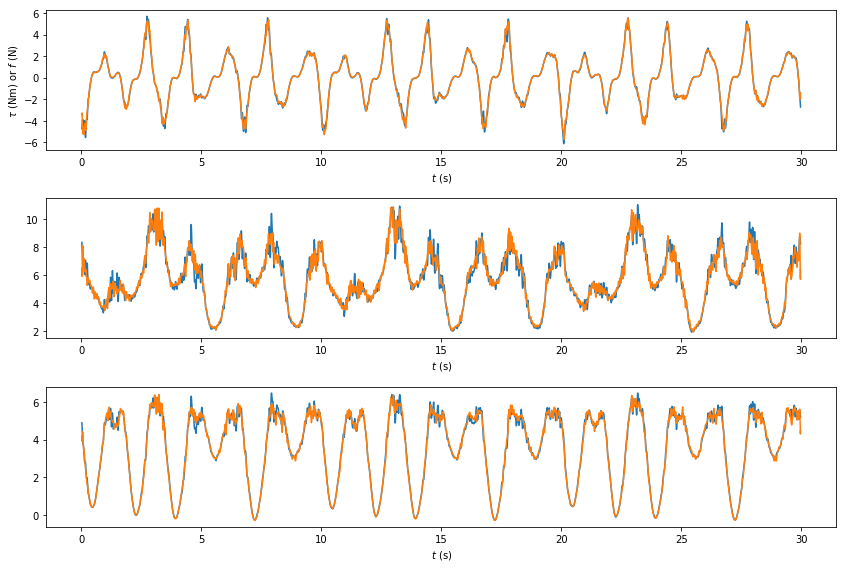

In [81]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [89]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx    6.93476694440786   ⎤
⎢                           ⎥
⎢L1xy  -5.15035491219744e-14⎥
⎢                           ⎥
⎢L1xz  6.36217715962074e-18 ⎥
⎢                           ⎥
⎢L1yy    5.55478691001959   ⎥
⎢                           ⎥
⎢L1yz  -2.69482133504241e-6 ⎥
⎢                           ⎥
⎢L1zz   9.33239228412096e-6 ⎥
⎢                           ⎥
⎢l1x   -8.99389275993746e-17⎥
⎢                           ⎥
⎢l1y    7.18681513674972e-9 ⎥
⎢                           ⎥
⎢l1z    1.39591302400843e-8 ⎥
⎢                           ⎥
⎢ m₁     3.19711705900063   ⎥
⎢                           ⎥
⎢L2xx   0.0446961477391961  ⎥
⎢                           ⎥
⎢L2xy   0.00082606659873916 ⎥
⎢                           ⎥
⎢L2xz   0.00582767934044085 ⎥
⎢                           ⎥
⎢L2yy    0.146088627056155  ⎥
⎢                           ⎥
⎢L2yz  0.000212336300896343 ⎥
⎢                           ⎥
⎢L2zz    0.111681688930716  ⎥
⎢                           ⎥
⎢l2x     0.292234068345849  ⎥
⎢         

In [83]:
from identification import barycentric2standard_params

In [84]:
sdp_opt_std.x_result

array([ 6.93476694e+00, -5.15035491e-14,  6.36217716e-18,  5.55478691e+00,
       -2.69482134e-06,  9.33239228e-06, -8.99389276e-17,  7.18681514e-09,
        1.39591302e-08,  3.19711706e+00,  4.46961477e-02,  8.26066599e-04,
        5.82767934e-03,  1.46088627e-01,  2.12336301e-04,  1.11681689e-01,
        2.92234068e-01, -5.20542840e-04, -5.81210585e-02,  2.99822334e+00,
        4.81911557e-03, -2.06258707e-02, -1.35500894e-03,  1.07771262e-01,
        1.12091132e-03,  1.22873801e-01,  4.53185640e-01,  8.26759042e-02,
        2.02840778e-02,  2.10997770e+00])

In [85]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def.params)

([6.93476694440786, -5.15035491221766e-14, 6.36217676693284e-18, 5.55478691001959, -2.69482133501103e-6, 9.33239228410481e-6], [-2.813125886216004e-17, 2.247904910618506e-09, 4.366161758383573e-09], 3.1971170590006337)
([0.0435693709710394, 0.000775329767422557, 0.000162673283973115, 0.116478155096301, 0.000222427110491160, 0.0831978129887420], [0.09746907924891887, -0.0001736170994839562, -0.019385166447340396], 2.9982233401377956)
([0.00138460109297596, -0.00286855855159073, 0.00300164980595019, 0.0102400568540123, 0.00191570856910424, 0.0222980797482639], [0.21478219440917587, 0.03918330710438234, 0.009613408631879546], 2.109977699714676)
